In [1]:
%matplotlib inline
import json
import pandas as pd
from collections import Counter

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tag import pos_tag

import seaborn as sns
import warnings

nltk.download('wordnet')
nltk.download('omw-2.4')
nltk.download('averaged_perceptron_tagger')
warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Error loading omw-2.4: Package 'omw-2.4' not found in
[nltk_data]     index
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Tyler\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
def parse_inference_data(obj):
    reorganized = []
    for idx, record in enumerate(obj['dataset']):
        reorganized.append(record[str(idx)]['response'])
    return { 'dataset': reorganized }

In [3]:
df = pd.read_json('./data/sentence_dataset.json')

llm_file = open('./data/sentence_inferences.json', 'r')
llm_json = json.load(llm_file)
llm_obj = parse_inference_data(llm_json)
llm_df = pd.DataFrame(llm_obj)

rlhf_file = open('./data/sentence_rlhf_inferences.json', 'r')
rlhf_json = json.load(rlhf_file)
rlhf_obj = parse_inference_data(rlhf_json)
rlhf_df = pd.DataFrame(rlhf_obj)

df = df.rename(columns={'dataset': 'input_sentence'})
df['llm_sentence'] = llm_df['dataset'].values
df['rlhf_sentence'] = rlhf_df['dataset'].values

df


,input_sentence,llm_sentence,rlhf_sentence
0,When the young people returned to the ballroom...,When the young people returned to the ballroom...,When the young people returned to the ballroom...
1,"Instead of an interior scene, it was a winter ...","Instead of an interior, the floor, covered wit...","Instead of a winter scene, it was a winter spo..."
2,The numerous palms and evergreens that had dec...,"The floor was covered with tiny cotton wads, m...","The floor was covered with tiny cotton wads, a..."
3,Also diamond dust had been lightly sprinkled o...,"At either end of the wall, on the wall, hung a...","Also, some Diamond dust had been brought to th..."
4,And this was the game.\nThe girls were gathere...,This was the game. The girls were gathered at ...,This was the game. The girls were gathered at ...
...,...,...,...
21480,"So are dogs, cats, cows, horses, frogs, fish, ...","Animals can be divided into two classes, verte...","It is divided into three: animals, plants, and..."
21481,Vertebrates can be further divided into mammal...,Animals that have backbone can be divided into...,"Vertebrates can be divided into: animals, bird..."
21482,Invertebrates can be divided into arthropods (...,"Mollusks, sponges, jellyfish, and a bunch of o...",Invertebrates are divided into arthropeds like...
21483,There are at least thirty kinds of invertebrat...,"There are at least five kinds of vertebrates, ...","There are at least thirty kinds of animals, co..."


In [4]:
# Calculate word counts
df['input_wc'] =  df.input_sentence.apply(lambda x: len(str(x).split(' ')))
df['llm_wc'] =  df.llm_sentence.apply(lambda x: len(str(x).split(' ')))
df['rlhf_wc'] =  df.rlhf_sentence.apply(lambda x: len(str(x).split(' ')))


In [5]:
# Calculate character counts
df['input_cc'] =  df.input_sentence.str.len()
df['llm_cc'] =  df.llm_sentence.str.len()
df['rlhf_cc'] =  df.rlhf_sentence.str.len()


In [6]:
df.describe()

,input_wc,llm_wc,rlhf_wc,input_cc,llm_cc,rlhf_cc
count,21485.000000,21485.000000,21485.000000,21485.000000,21485.000000,21485.000000
mean,22.642309,17.302723,17.162206,126.441192,98.785478,89.775704
std,18.205362,13.800024,11.539175,103.907750,76.882630,60.978284
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000
25%,11.000000,9.000000,9.000000,58.000000,51.000000,48.000000
50%,18.000000,14.000000,15.000000,100.000000,80.000000,76.000000
75%,29.000000,22.000000,22.000000,161.000000,123.000000,116.000000
max,190.000000,210.000000,138.000000,1181.000000,1117.000000,792.000000


In [7]:
desc = df.describe()
# Calculate mean word count reduction (mwcr)
llm_mwcr = desc.llm_wc[1] / desc.input_wc[1]
rlhf_mwcr = desc.rlhf_wc[1] / desc.input_wc[1]

print(f'{llm_mwcr:.2f} {rlhf_mwcr:.2f}')

0.76 0.76


In [8]:
desc = df.describe()
# Calculate mean characters per word (mcpw)
input_mcpw = desc.input_cc[1] / desc.input_wc[1]
llm_mcpw = desc.llm_cc[1] / desc.llm_wc[1]
rlhf_mcpw = desc.rlhf_cc[1] / desc.rlhf_wc[1]

print(f'{input_mcpw:.2f} {llm_mcpw:.2f} {rlhf_mcpw:.2f}')

5.58 5.71 5.23


In [9]:
stop = stopwords.words('english')

df['input_sw'] = df.input_sentence.apply(lambda x: len([x for x in x.split() if x in stop]))
df['llm_sw'] = df.llm_sentence.apply(lambda x: len([x for x in x.split() if x in stop]))
df['rlhf_sw'] = df.rlhf_sentence.apply(lambda x: len([x for x in x.split() if x in stop]))

df.describe()

,input_wc,llm_wc,rlhf_wc,input_cc,llm_cc,rlhf_cc,input_sw,llm_sw,rlhf_sw
count,21485.000000,21485.000000,21485.000000,21485.000000,21485.000000,21485.000000,21485.000000,21485.000000,21485.000000
mean,22.642309,17.302723,17.162206,126.441192,98.785478,89.775704,9.981708,7.298860,7.987014
std,18.205362,13.800024,11.539175,103.907750,76.882630,60.978284,9.056479,6.816251,6.184095
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,9.000000,9.000000,58.000000,51.000000,48.000000,4.000000,3.000000,4.000000
50%,18.000000,14.000000,15.000000,100.000000,80.000000,76.000000,8.000000,6.000000,7.000000
75%,29.000000,22.000000,22.000000,161.000000,123.000000,116.000000,13.000000,9.000000,11.000000
max,190.000000,210.000000,138.000000,1181.000000,1117.000000,792.000000,99.000000,114.000000,73.000000


In [10]:
desc = df.describe()
# Calculate percent stopwords of words in sentences 
input_swc = desc.input_sw[1] / desc.input_wc[1]
llm_swc = desc.llm_sw[1] / desc.llm_wc[1]
rlhf_swc = desc.rlhf_sw[1] / desc.rlhf_wc[1]

print(f'{input_swc * 100:.2f} {llm_swc * 100:.2f} {rlhf_swc * 100:.2f}')

44.08 42.18 46.54


<Axes: xlabel='input_wc', ylabel='Count'>

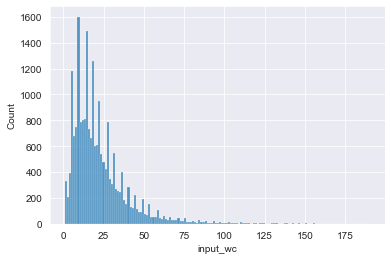

In [11]:
sns.histplot(data=df, x='input_wc')

<Axes: xlabel='llm_wc', ylabel='Count'>

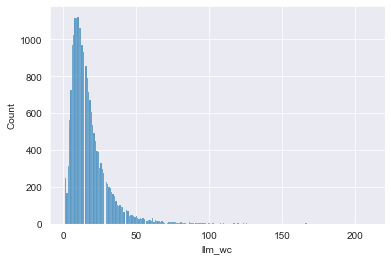

In [12]:
sns.histplot(data=df, x='llm_wc')

<Axes: xlabel='rlhf_wc', ylabel='Count'>

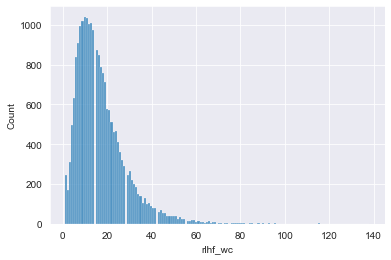

In [13]:
sns.histplot(data=df, x='rlhf_wc')

In [14]:
import string

def clean_sentence(dataframe, input_col_name, output_col_name):
    target = getattr(dataframe, input_col_name)
    dataframe[output_col_name] = target.apply(lambda x: " ".join(x.lower() for x in x.split()))
    output = getattr(dataframe, output_col_name)
    output = output.str.replace('[^\w\s]','')
    output  = output.str.replace('\d+','')
    output  = output.apply(lambda x: ''.join(char for char in x if char not in string.punctuation))
    output = output.apply(lambda x: ' '.join(w for w in x.split() if w not in stop))
    return output

df['clean_input'] = clean_sentence(df, 'input_sentence', 'clean_input')
df['clean_llm'] = clean_sentence(df, 'llm_sentence', 'clean_llm')
df['clean_rlhf'] = clean_sentence(df, 'rlhf_sentence', 'clean_rlhf')

df

,input_sentence,llm_sentence,rlhf_sentence,input_wc,llm_wc,rlhf_wc,input_cc,llm_cc,rlhf_cc,input_sw,llm_sw,rlhf_sw,clean_input,clean_llm,clean_rlhf
0,When the young people returned to the ballroom...,When the young people returned to the ballroom...,When the young people returned to the ballroom...,14,15,13,91,81,77,5,6,6,young people returned ballroom presented decid...,young people returned ballroom different appea...,young people returned ballroom different appea...
1,"Instead of an interior scene, it was a winter ...","Instead of an interior, the floor, covered wit...","Instead of a winter scene, it was a winter spo...",31,25,41,184,154,203,13,9,19,instead interior scene winter landscape floor ...,instead interior floor covered snowwhite canva...,instead winter scene winter sports world floor...
2,The numerous palms and evergreens that had dec...,"The floor was covered with tiny cotton wads, m...","The floor was covered with tiny cotton wads, a...",22,22,19,130,127,106,9,9,9,numerous palms evergreens decorated room powde...,floor covered tiny cotton wads much like snow ...,floor covered tiny cotton wads fallen palm tre...
3,Also diamond dust had been lightly sprinkled o...,"At either end of the wall, on the wall, hung a...","Also, some Diamond dust had been brought to th...",43,43,42,245,263,231,19,18,23,also diamond dust lightly sprinkled glittering...,either end wall wall hung beautiful bearskin r...,also diamond dust brought struggled found glit...
4,And this was the game.\nThe girls were gathere...,This was the game. The girls were gathered at ...,This was the game. The girls were gathered at ...,34,31,33,164,145,157,18,16,16,game girls gathered one end room boys one end ...,game girls gathered one end room boys game pla...,game girls gathered one end room boys one end ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21480,"So are dogs, cats, cows, horses, frogs, fish, ...","Animals can be divided into two classes, verte...","It is divided into three: animals, plants, and...",23,10,9,138,75,55,9,4,3,dogs cats cows horses frogs fish animals divid...,animals divided two classes vertebrates invert...,divided three animals plants protists
21481,Vertebrates can be further divided into mammal...,Animals that have backbone can be divided into...,"Vertebrates can be divided into: animals, bird...",12,14,10,86,97,69,5,6,3,vertebrates divided mammals fish birds reptile...,animals backbone divided mammals fish reptiles...,vertebrates divided animals birds reptile ambeans
21482,Invertebrates can be divided into arthropods (...,"Mollusks, sponges, jellyfish, and a bunch of o...",Invertebrates are divided into arthropeds like...,26,9,16,177,65,114,9,4,5,invertebrates divided arthropods like insects ...,mollusks sponges jellyfish bunch subgroups,invertebrates divided arthropeds like insects ...
21483,There are at least thirty kinds of invertebrat...,"There are at least five kinds of vertebrates, ...","There are at least thirty kinds of animals, co...",15,14,15,91,92,86,6,5,6,least thirty kinds invertebrates compared five...,least five kinds vertebrates compared thirty k...,least thirty kinds animals compared five kinds...


In [15]:
# token frequency analysis
input_tokens = ' '.join(df.clean_input).split()
llm_tokens = ' '.join(df.clean_llm).split()
rlhf_tokens = ' '.join(df.clean_rlhf).split()


In [16]:
input_freq = pd.Series(input_tokens).value_counts().to_dict()
llm_freq = pd.Series(llm_tokens).value_counts().to_dict()
rlhf_freq = pd.Series(rlhf_tokens).value_counts().to_dict()

agg = list()
agg.append(list(input_freq.items())[:10])
agg.append(list(llm_freq.items())[:10])
agg.append(list(rlhf_freq.items())[:10])

input_tokens = sorted(list(set(input_tokens)))
llm_tokens = sorted(list(set(llm_tokens)))
rlhf_tokens = sorted(list(set(rlhf_tokens)))


len(input_tokens)


29074

In [17]:
# Tokens in input but not in output

def token_missing_list(a, b):
    removed_tokens = []
    ptr = 0
    for token in a:
        if ptr >= len(b):
            removed_tokens.append(token)
            continue
        if token == b[ptr]:
            ptr += 1
            continue
        if sorted([token, b[ptr]])[0] == token:
            removed_tokens.append(token)
        ptr += 1
    return removed_tokens

missing_llm = token_missing_list(input_tokens, llm_tokens)
missing_after_training = token_missing_list(llm_tokens, rlhf_tokens)
missing_rlhf = token_missing_list(input_tokens, rlhf_tokens)
    

In [18]:

def lemmatize_sentence(dataframe, input_col_name):
    wordnet_lemmatizer = WordNetLemmatizer()
    target = getattr(dataframe, input_col_name)
    return target.apply(lambda x: " ".join(wordnet_lemmatizer.lemmatize(w) for w in x.split()))

df['lemma_input'] = lemmatize_sentence(df, 'clean_input')
df['lemma_llm'] = lemmatize_sentence(df, 'clean_llm')
df['lemma_rlhf'] = lemmatize_sentence(df, 'clean_rlhf')



In [19]:
# token frequency analysis
input_lemma_tokens = ' '.join(df.lemma_input).split()
llm_lemma_tokens = ' '.join(df.lemma_llm).split()
rlhf_lemma_tokens = ' '.join(df.lemma_rlhf).split()

input_lemma_freq = pd.Series(' '.join(df.lemma_input).split()).value_counts().to_dict()
llm_lemma_freq = pd.Series(' '.join(df.lemma_llm).split()).value_counts().to_dict()
rlhf_lemma_freq = pd.Series(' '.join(df.lemma_rlhf).split()).value_counts().to_dict()

agg = list()
agg.append(list(input_lemma_freq.items())[:10])
agg.append(list(llm_lemma_freq.items())[:10])
agg.append(list(rlhf_lemma_freq.items())[:10])
agg

input_lemma_tokens = sorted(list(set(input_lemma_tokens)))
llm_lemma_tokens = sorted(list(set(llm_lemma_tokens)))
rlhf_lemma_tokens = sorted(list(set(rlhf_lemma_tokens)))
# Tokens in input but not in output

def token_missing_list(a, b):
    removed_tokens = []
    ptr = 0
    for token in a:
        if ptr >= len(b):
            removed_tokens.append(token)
            continue
        if token == b[ptr]:
            ptr += 1
            continue
        if sorted([token, b[ptr]])[0] == token:
            removed_tokens.append(token)
        ptr += 1
    return removed_tokens


missing_lemma_llm = token_missing_list(input_lemma_tokens, llm_lemma_tokens)
missing_lemma_after_training = token_missing_list(llm_lemma_tokens, rlhf_lemma_tokens)
missing_lemma_rlhf = token_missing_list(input_lemma_tokens, rlhf_lemma_tokens)

len(input_lemma_tokens)

25344

In [20]:
# creating the ngrams
def get_ngrams(df_column, func='bigrams'):
    run = getattr(nltk, func)
    ngrams = run(' '.join(df_column).split())
    freq_ngrams = pd.Series(ngrams).value_counts().to_dict()
    return list(freq_ngrams.items())

In [21]:
input_bigrams = get_ngrams(df.clean_input)
print(len(input_bigrams))
input_bigrams[:10]

216225


[(('one', 'day'), 164),
 (('united', 'states'), 100),
 (('years', 'ago'), 77),
 (('could', 'see'), 58),
 (('long', 'time'), 57),
 (('every', 'day'), 57),
 (('little', 'girl'), 55),
 (('years', 'old'), 55),
 (('th', 'century'), 55),
 (('new', 'york'), 46)]

In [22]:
llm_bigrams = get_ngrams(df.clean_llm)
print(len(llm_bigrams))
llm_bigrams[:10]

167033


[(('one', 'day'), 122),
 (('united', 'states'), 92),
 (('years', 'old'), 71),
 (('long', 'time'), 64),
 (('years', 'ago'), 58),
 (('old', 'man'), 52),
 (('could', 'see'), 50),
 (('many', 'people'), 49),
 (('every', 'day'), 47),
 (('th', 'century'), 46)]

In [23]:
rlhf_bigrams = get_ngrams(df.clean_rlhf)
print(len(rlhf_bigrams))
rlhf_bigrams[:10]

140233


[(('united', 'states'), 174),
 (('one', 'day'), 144),
 (('long', 'time'), 109),
 (('large', 'number'), 94),
 (('young', 'people'), 90),
 (('great', 'deal'), 77),
 (('hard', 'time'), 71),
 (('years', 'old'), 69),
 (('years', 'ago'), 64),
 (('many', 'different'), 62)]

In [24]:
input_trigrams = get_ngrams(df.clean_input, func='trigrams')
print(len(input_trigrams))
input_trigrams[:10]

244890


[(('world', 'war', 'ii'), 17),
 (('long', 'time', 'ago'), 10),
 (('one', 'two', 'three'), 10),
 (('late', 'th', 'century'), 9),
 (('th', 'th', 'centuries'), 9),
 (('let', 'us', 'go'), 9),
 (('traumatic', 'brain', 'injury'), 9),
 (('million', 'years', 'ago'), 8),
 (('one', 'day', 'mother'), 7),
 (('old', 'man', 'said'), 7)]

In [25]:
llm_trigrams = get_ngrams(df.clean_llm, func='trigrams')
print(len(llm_trigrams))
llm_trigrams[:10]

187247


[(('world', 'war', 'ii'), 15),
 (('long', 'time', 'ago'), 10),
 (('seventytwo', 'years', 'old'), 8),
 (('united', 'states', 'america'), 7),
 (('million', 'years', 'ago'), 7),
 (('one', 'two', 'three'), 7),
 (('th', 'th', 'centuries'), 6),
 (('one', 'day', 'saw'), 6),
 (('late', 'th', 'century'), 6),
 (('seven', 'years', 'old'), 6)]

In [26]:
rlhf_trigrams = get_ngrams(df.clean_rlhf, func='trigrams')
print(len(rlhf_trigrams))
rlhf_trigrams[:10]

168488


[(('hard', 'time', 'getting'), 23),
 (('early', 'th', 'century'), 19),
 (('large', 'number', 'people'), 18),
 (('idea', 'idea', 'idea'), 16),
 (('young', 'people', 'returned'), 15),
 (('united', 'states', 'america'), 15),
 (('people', 'returned', 'ballroom'), 15),
 (('ballroom', 'different', 'appearance'), 14),
 (('returned', 'ballroom', 'different'), 14),
 (('world', 'war', 'ii'), 12)]

In [27]:
def count_parts_of_speech_tags(df_column):
    tokens = ' '.join(df_column).split()
    return Counter([j for i,j in pos_tag(tokens)])

In [28]:
input_pos = count_parts_of_speech_tags(df.clean_input)
llm_pos = count_parts_of_speech_tags(df.clean_llm)
rlhf_pos = count_parts_of_speech_tags(df.clean_rlhf)


In [29]:
def show_pos_changes(inp, output):
    res = dict()
    for k in inp.keys():
        res[k] = (output[k] / inp[k], abs(inp[k] - output[k]))
    return res


In [30]:
show_pos_changes(input_pos, llm_pos) # Adverbs: RB

{'JJ': (0.7514385553765354, 11879),
 'NNS': (0.8102168581386343, 5881),
 'VBD': (0.793516078017923, 3917),
 'RB': (0.6621700879765395, 5760),
 'VBN': (0.7525943396226416, 2098),
 'NN': (0.7658538511139477, 17793),
 'IN': (0.7363778910231282, 1345),
 'VBZ': (0.7408916586768935, 1081),
 'VBG': (0.7287860771808453, 2509),
 'VBP': (0.8048298770087081, 2174),
 'CD': (0.790058170280275, 794),
 'MD': (0.7673325499412456, 792),
 'VB': (0.7774113767518549, 1350),
 'RP': (0.7289377289377289, 74),
 'DT': (0.672665916760405, 291),
 'JJR': (0.784629981024668, 227),
 'RBR': (0.7750865051903114, 130),
 'JJS': (0.7130528586839266, 266),
 'FW': (0.642512077294686, 74),
 'WDT': (0.8115942028985508, 13),
 'WP$': (0.6538461538461539, 36),
 'PRP': (0.7973856209150327, 93),
 'WP': (0.7611940298507462, 16),
 'CC': (0.5815217391304348, 77),
 'NNP': (0.8455882352941176, 21),
 'UH': (0.6451612903225806, 11),
 'RBS': (0.52, 12),
 'WRB': (0.975609756097561, 1),
 'PRP$': (0.3076923076923077, 9),
 'POS': (0.3333333

In [31]:
show_pos_changes(input_pos, rlhf_pos) 
# past tense verb; preposition or conjunction, subordinating; verb, present tense, 3rd person singular;
# verb, present participle or gerund; verb, past tense;

{'JJ': (0.7134606934360026, 13694),
 'NNS': (0.7113721440557635, 8944),
 'VBD': (0.686136004217185, 5954),
 'RB': (0.5158357771260997, 8255),
 'VBN': (0.6351415094339623, 3094),
 'NN': (0.7323630429919332, 20338),
 'IN': (0.5215601724813799, 2441),
 'VBZ': (0.5630393096836049, 1823),
 'VBG': (0.5688033726083667, 3989),
 'VBP': (0.7561720082592692, 2716),
 'CD': (0.9093072448439978, 343),
 'MD': (0.681551116333725, 1084),
 'VB': (0.7253091508656224, 1666),
 'RP': (0.6666666666666666, 91),
 'DT': (0.5174353205849269, 429),
 'JJR': (0.6963946869070209, 320),
 'RBR': (0.698961937716263, 174),
 'JJS': (0.807982740021575, 178),
 'FW': (0.6038647342995169, 82),
 'WDT': (0.463768115942029, 37),
 'WP$': (0.08653846153846154, 95),
 'PRP': (0.39869281045751637, 276),
 'WP': (0.5223880597014925, 32),
 'CC': (0.42934782608695654, 105),
 'NNP': (0.6029411764705882, 54),
 'UH': (0.5161290322580645, 15),
 'RBS': (1.32, 8),
 'WRB': (0.24390243902439024, 31),
 'PRP$': (0.15384615384615385, 11),
 'POS': 

In [32]:
def parse_training_data(obj):
    accepted = []
    for idx, record in enumerate(obj['dataset']):
        accepted.append(record[str(idx)]['accepted'])
    return { 'accepted': accepted }

In [33]:
sft_file = open('./data/sentence_sft_second_dataset.json', 'r')
sft_json = json.load(sft_file)
sft_obj = parse_training_data(sft_json)
sft_df = pd.DataFrame(sft_obj)
sft_vc = sft_df.value_counts()
print(f'{sft_vc[1] / sum(sft_vc) * 100:.2f}% acceptance of generated rewrite, using falcon-7b model')

23.53% acceptance of generated rewrite, using falcon-7b model


In [34]:
rw_file = open('./data/sentence_sft_rlhf_dataset.json', 'r')
rw_json = json.load(rw_file)
rw_obj = parse_training_data(rw_json)
rw_df = pd.DataFrame(rw_obj)
rw_vc = rw_df.value_counts()
print(f'{rw_vc[1] / sum(rw_vc) * 100:.2f}% acceptance of generated rewrite, using rlhf tuned opt-1.3b model')


30.79% acceptance of generated rewrite, using rlhf tuned opt-1.3b model


In [35]:
ctx_file = open('./data/sentence_sft_dataset.json', 'r')
ctx_json = json.load(ctx_file)
ctx_obj = parse_training_data(ctx_json)
ctx_df = pd.DataFrame(ctx_obj)
ctx_vc = ctx_df.value_counts()
print(f'{ctx_vc[1] / sum(ctx_vc) * 100:.2f}% acceptance of generated rewrite, using prompt engineered context on falcon-7b model')

36.09% acceptance of generated rewrite, using prompt engineered context on falcon-7b model
